# 加载与函数

In [23]:
import plotly.graph_objects as go
import datetime
from datetime import datetime
import random
import calendar
import time
import tensorflow as tf
from sklearn import svm
from subprocess import call
from scipy import signal
from sklearn import tree
import sklearn
from matplotlib.lines import Line2D
import statsmodels.tsa.stattools as ts
import matplotlib.ticker as mtick
import matplotlib.collections as collections
from numpy import linalg
from IPython.display import Image
import os
import graphviz
import sys
import csv
import pandas as pd 
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import numpy as np
import warnings
from sklearn.tree import export_graphviz
from sklearn import datasets
warnings.filterwarnings("ignore")
import math
import operator
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager as fm
from sklearn import preprocessing
from sklearn import linear_model
from statsmodels.tsa.arima_model import ARIMA
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy import stats
from copy import deepcopy
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.feature_extraction import DictVectorizer
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import cross_validate

from WindPy import w
w.start()
#趋势划分函数

from numpy import exp, array, random, dot
#激活函数及坡度
def sig(x):
    return 1 / (1 + exp(-x))

def sig_drv(x):
    return x * (1-x)

#生成初始神经网络
def gen_layer(x,y,nnum):
    res = [2 * random.random((len(x[0]), nnum[0])) - 1]
    if len(nnum) > 1:
        for i in range(1,len(nnum)):
            res.append(2 * random.random((nnum[i-1], nnum[i])) - 1)
    res.append(2 * random.random((nnum[-1], len(y[0]))) - 1)
    return res

#输入结果
def calc(x, nn):
    res = []
    for i in range(len(nn)):
        if i == 0:
            res.append(sig(dot(x, nn[i])))
        else:
            res.append(sig(dot(res[-1], nn[i])))
    return res

#纠正
def correct(x, y, nnum, time,prt):
    layer = gen_layer(x,y,nnum)
    for j in range(time):
        res = calc(x, layer)
        det = []
        err = []
        adj = []
        for i in range(len(layer)-1,-1,-1):
            if i == len(layer)-1:
                err.append(y - res[-1])
                det.append(err[0] * sig_drv(res[-1]))
            else:
                err.append(det[-1].dot((layer[i+1]).T))
                det.append(err[-1] * sig_drv(res[i]))
        
        det = det[::-1]
        for i in range(len(det)):
            if i == 0:
                adj.append((x.T).dot(det[i]))
            else:
                adj.append((res[i-1].T).dot(det[i]))        
        for i in range(len(layer)):
            layer[i] += adj[i]
    if prt:
        print(layer)
    return layer

def und(data, l1, l2):
    i = 0
    res = [0] * len(data)

    while i < len(data)-1:
        if i + l1 >= len(data) - 1 - l2:
            for j in range(i, len(data)-l2):
                res[j] = res[i]
            break
        cur = data[i]
        
        next_id = min([(data).index(max(data[i+1+l1:i+1+l2])), data.index(min(data[i+1+l1:i+1+l2]))])
        res[i:next_id+1] = [- (-1) ** (data[next_id] > data[i])] * (next_id + 1 - i)
        i = next_id
    return res

#清理重复的月份
def date_clean(date,data):
    date_res = [date[0]]
    data_res = [[i[0]] for i in data]
    
    last = date[0]
    
    for i in range(len(date[1:])):
        cur = date[i]
        if cur.month != last.month:
            date_res.append(cur)
            for j in range(len(data_res)):
                data_res[j].append(data[j][i])
        last = date[i]

    return date_res, data_res

#时间序列模型预测
def ts_predict(data, date, n_steps):
    
    f, err95, ci95 = best_mdl.forecast(steps=n_steps)
    idx = [date[-1]]
    for i in range(n_steps-1):
        idx.append(next_month(idx[-1]))
    fc_all = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
    return fc_all['forecast'][1]

#移动平均线MA
def ma(data, l_ma):
    res = []
    for i in range(l_ma-1,len(data)):
        res.append(np.mean(data[i-l_ma+1:i+1]))
    return res

#ROCSMA变化率移动平均
def rocsma(d1,i1,l_roc,l_sma):
    res = 0
    for x in range(l_sma):
        res += (d1[i1-x]/d1[i1-x-l_roc]-1)/l_sma
    return res

#KST公式
def kst(d2,roc_l1,roc_l2,roc_l3,roc_l4,sma_l1,sma_l2,sma_l3,sma_l4):
    res = []
    for i in range(roc_l4+sma_l4, len(d2)):
        rocma1 = rocsma(d2,i,roc_l1,sma_l1)
        rocma2 = rocsma(d2,i,roc_l2,sma_l2)
        rocma3 = rocsma(d2,i,roc_l3,sma_l3)
        rocma4 = rocsma(d2,i,roc_l4,sma_l4)
        res.append(rocma1 * 1 + rocma2 * 2 + rocma3 * 3 + rocma4 * 4)
    return res
    
#斜率
def slope(data):
    res = [0]
    for i in range(1,len(data)):
        res.append(-(-1) ** (data[i]>data[i-1]))
    res[0] = res[1]
    return res
    
#获取下个月末
def next_month(date):
    if date.month == 12:
        res = date.replace(year = date.year + 1, month = 1, day = calendar.monthrange(int(date.year+1), 1)[1])
        
    else:
        res = date.replace(month = date.month + 1, day = calendar.monthrange(int(date.year), date.month + 1)[1])
        
    return res

#相对强度
def rel_str(data, i1, i2):
    return (np.array(data[i1])/np.mean(data[i1])) / (np.array(data[i2])/np.mean(data[i2]))

#训练与验证集
def trvd(x, y, ratio):
    train_x = x[:int(len(x)*ratio)]
    valid_x = x[int(len(x)*ratio):]
    train_y = y[:int(len(x)*ratio)]
    valid_y = y[int(len(x)*ratio):]
    
    print(len(train_x), len(valid_x), len(train_y), len(valid_y))
    return train_x, valid_x, train_y, valid_y

#交叉变换趋势
def cross(d1,d2,cd):
    comp = [-(-1) ** (d1[i] > d2[i]) for i in range(len(d1))]
    res = [-comp[0]]
    c = 0
    
    for i in range(1,len(comp)):
        if comp[i] * comp[i-1] == -1 and c == 0:
            sl1 = -(-1)**(d1[i]>d1[i-1])
            sl2 = -(-1)**(d2[i]>d2[i-1])
            res.append(sl1*sl2)
            c += cd
        else:
            res.append(res[-1])
            c = max(0,c-1)
    return res

#大小对比
def comp(d1,d2):
    res = [-(-1) ** (d1[i] > d2[i]) for i in range(len(d1))]
    return res

#标准化
def std(data):
    res = []
    for i in range(len(data)):
        res.append((data[i] - np.mean(data[:i+1]))/np.mean(data[:i+1]))
    return res

#普林格经济周期
def pring(b,s,c):
    if b == 1 and s == c == -1:
        return -3
    if b == s == 1 and c == -1:
        return -1
    if b == s == c == 1:
        return 1
    if b == -1 and s == c == 1:
        return 3
    if b == s == -1 and c == 1:
        return 1
    if b == s == c == -1:
        return -1
    else:
        return 0

def dupe_legend(label, color):
    line = Line2D([0], [0], linestyle='none', mfc= 'white',
                mec=color, marker=r'$\mathregular{{{}}}$'.format(label))
    return line

#平滑折线
def smooth(data):
    for i in range(len(data)-4):
        if data[i] * data[i+2] == 1 and data[i] * data[i+1] == -1:
            data[i+1] = data[i]
        elif data[i] * data[i+3] == 1 and all(data[i+1:i+3]) != data[i]:
            for j in range(2):
                data[i+j+1] = data[i]
        elif data[i] * data[i+4] == 1 and all(data[i+1:i+4]) != data[i]:
            for j in range(3):
                data[i+j+1] = data[i]
    return data

def data_pro(data,l):
    df = []
    #从第l个周期开始
    for i in range(l-1,len(date)):
        temp = []

        for j in range(len(data)):
            i = int(i)
            j = int(j)
            #选取第j组第i+l时间点前l长度的数据
            il = data[j][i-l+1:i+1]

            #第i+l时间点前l长度内的最大波动幅度————1
            temp.append(((max(il)-min(il))/np.mean(il)))

            #第i+l时间点前l长度内的反转频率————2
            spike = 0
            dirc = -(-1) ** (il[1] > il[0]) 
            for k in range(1,l):
                spike += (-(-1) ** (il[k] > il[k-1]) != dirc)
                dirc = -(-1) ** (il[k] > il[k-1])
            temp.append(spike/l)

            #第i+l时间点l个时长的移动平均值，并根据之前的平均值标准化————3
            temp.append(np.mean(il)/np.mean(data[j][:i])-1)    

            #第i+l时间点9个时长的移动平均值，并根据之前的平均值标准化————6
            il = data[j][i-9+1:i+1]
            temp.append(np.mean(il)/np.mean(data[j][:i])-1)    

             
        df.append(temp)
    return df

def smooth2(data):
    for i in range(len(data)-5):
        if data[i] * data[i+5] == 1 and all(data[i+1:i+4]) != data[i]:
            for j in range(4):
                data[i+j+1] = data[i]
    return data
    
def date2num(date):
    d8 = []
    for i in range(len(date)):
        d8.append(int((date[i] - date[0]).days))
    return d8
    
def find1y(date):
    last = date[0]
    for i in range(len(date)):
        cur = date[i]
        if cur.year != last.year:
            return i
        last = date[i]
######################################评估方式

#准确度计算
def acc(d1,d2):
    return round(sum(np.array(d1) == np.array(d2))/ len(d1),3)

#收益率计算
def profit(data, ud):
    money = 1
    num = 0
    prt = 0   #显示买卖记录
    m2y = 1   #是否年化收益
    for i in range(len(data)):
        if ud[i] == 1 and num == 0:
            if prt:
                print('in', date[11:][i], 'money', money, 'num', num, 'price', data[i])
            num = money/data[i]
            money = 0
        if ud[i] == -1 and money == 0:
            if prt:
                print('out', date[11:][i], 'money', money, 'num', num, 'price', data[i])
            money = num * data[i]
            num = 0
    if prt:
        print('结果',money+num*data[-1])
    if m2y:
        return (money+num*data[-1]) ** (1/len(data)*12)
    return money+num*data[-1]

#错误区间占比
def wrong_div(data, ud):
    c_div = 1
    c_wrong = 0
    l_wrong = 1
    l_all = 0
    dirc = ud[0]
    last = data[0]
    for i in range(1,len(data)):
        l_wrong += 1
        if ud[i] == 0:
            return str(c_wrong)+'/'+str(c_div), str(l_all)+'/'+str(len(data))
        if ud[i] != dirc:
            c_div += 1
            if -(-1)**(data[i] > last) != dirc:
                c_wrong += 1
                l_all += l_wrong
            l_wrong = 1
            last = data[i]
            dirc = ud[i]

    return str(c_wrong)+'/'+str(c_div), str(l_all)+'/'+str(len(data))

#复杂度计算
def cpx(x):
    res = 1
    dirc = x[0]
    for i in range(len(x)):
        if x[i] != dirc:
            res += 1
            dirc = x[i]
    return res/len(x)


def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    rol_weighted_mean = pd.ewma(timeSeries, span=size)

    timeSeries.plot(color='blue', label='Original')
    rolmean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()

def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

# 自相关和偏相关图，默认阶数为31阶
def draw_acf_pacf(ts, lags=31):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()
    
def tsplot(y, lags=None, figsize=(10,8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):#定义局部样式
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)#自相关系数ACF图
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)#偏相关系数PACF图
        sm.qqplot(y, line='s', ax=qq_ax)#QQ图检验是否是正态分布
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return


random.seed(1)

# 读取数据

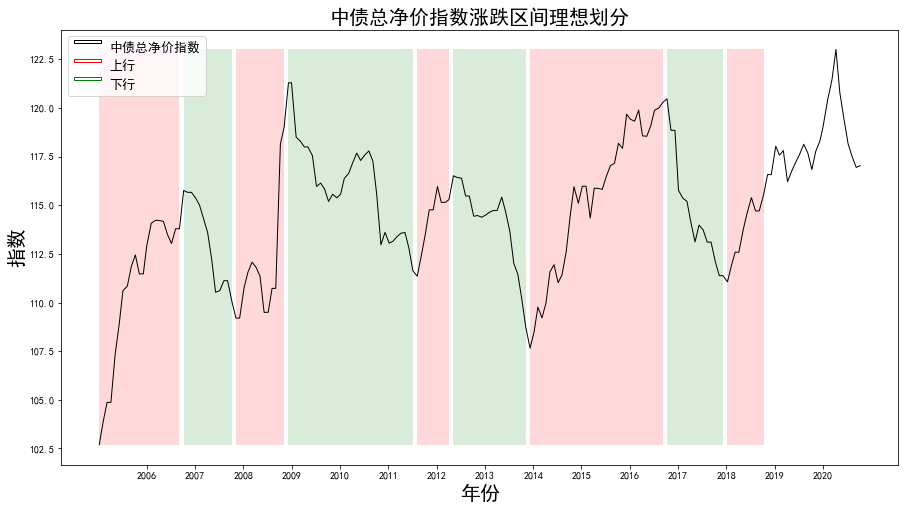

理想年化收益率 3.099%


In [71]:
int_list = [['M0265832','中债总净价指数'],['M0020188','股票'],['S0105896','商品'],['G1000116','OECD'],['M0041341','宏观景气先行'],
            ['M0041340','宏观景气一致'],['M0017126','PMI'], ['M0001384','M2']]

#起止时间
t0 = '2005-01-01'

#指数取值周期
dic = {'D':'天', 'W':'周', 'M':'月', 'Q':'季度', 'S':'半年', 'Y':'年'}
prd = 'M'

#移动平均线平均时长
l = 12

ind_list = []
for i in int_list:
    ind_list.append(i[0])

og = w.wsd(ind_list, 'close', t0, '-1D', Period = prd, Fill = 'Previous')

#所选市场
ii = 0

#指数与日期
date, data = date_clean(og.Times, og.Data)
date_s = [str(i) for i in date]
df = data_pro(data,l)
data_simp = [std(i) for i in data]
data_ma = [ma(i,l) for i in data]

d8 = date2num(date)
ud = und(data[0],6,24)
base_cpx = cpx(ud)
    
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('中债总净价指数涨跌区间理想划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[0], color='black', linewidth = 1, label = '中债总净价指数')

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8, ymin=min(data[0]), ymax=max(data[0]), where=np.array(ud) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8, ymin=min(data[0]), ymax=max(data[0]), where=np.array(ud) == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()
print('理想年化收益率', str( round( (profit(data[0][:-24],ud[:-24]) - 1) * 100,3 ) ) +  '%'   )

In [24]:
lr = sm.OLS(ud[11:-24], df[:-24]).fit()
[array(i)[lr.pvalues <= .05] for i in df]

for i in range(len(data)):
    exec('data'+str(i)+'=[df[j][7*i:7*(i+1)] for j in range(len(df))]')
print(i+1)
print('日期长度',len(d8))
print('数据长度',len(data1))
print('趋势划分长度',len(ud[:ud.index(0)]))

8
日期长度 190
数据长度 179
趋势划分长度 166


# 变量选择

# 神经网络——多组数据

[array([[ 0.38256834],
       [ 1.23522294],
       [ 0.66444272],
       [ 0.04428223],
       [ 0.16216887],
       [-0.66153453],
       [ 0.76337166],
       [ 0.52270692]]), array([[-9.98161656]])]


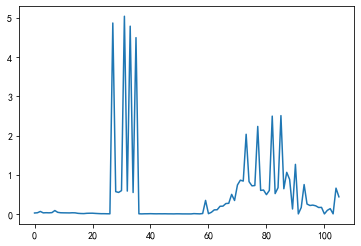

In [61]:
res_nnet1 = []

for i in range(48,len(d8)):
    temp = []
    
    cur_ud = und(data[0][:i], 6, 24)
    cur_ud = cur_ud[11:cur_ud.index(0)]
    y = array([cur_ud]).T
    
    for j in range(len(data)):
        exec('x'+str(j)+'=array(data'+str(j)+'[:len(cur_ud)])')
        temp.append(sum(calc(eval('data'+ str(j))[i-17:i-11], correct(eval('x'+str(j)), y, [4], 500, 0))[-1])[0])
    res_nnet1.append(temp)
    
res_nnet2 = []
for i in range(84,len(date)):
    cur_ud = und(data[0][48:i], 6, 24)
    cur_ud = cur_ud[:cur_ud.index(0)]
    x = array(res_nnet1[:len(cur_ud)])
    y = array([cur_ud]).T
    res_nnet2.append(sum(calc(res_nnet1[i-54:i-48], correct(x, y, [1], 500, 0))[-1]))
calc(x[-6:], correct(x, y, [1], 50, 1))[:0]
plt.plot(res_nnet2)
plt.show()

年化收益率 1.008
相对收益率 0.359
准确率 0.512
复杂度 2.151
区间错误率 ('3/12', '28/106')


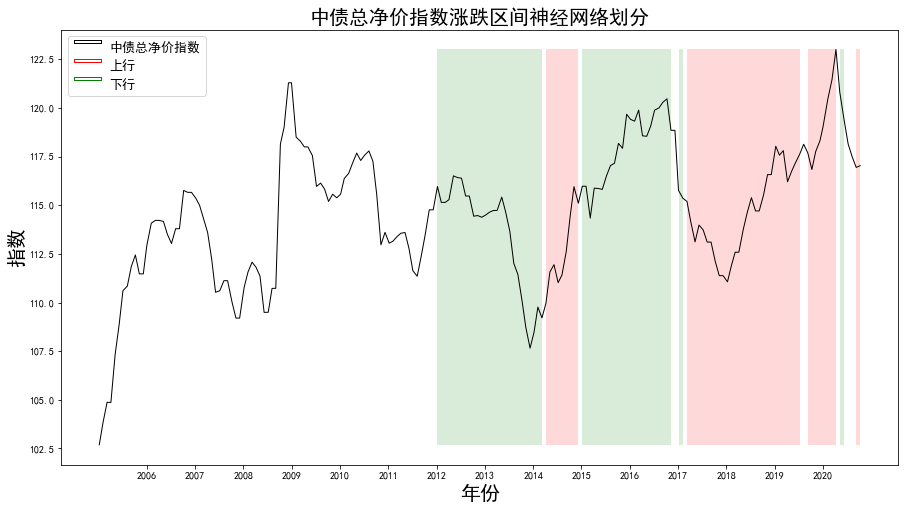

年化收益率 1.011
相对收益率 0.457
准确率 0.537
复杂度 2.151
区间错误率 ('3/12', '28/106')


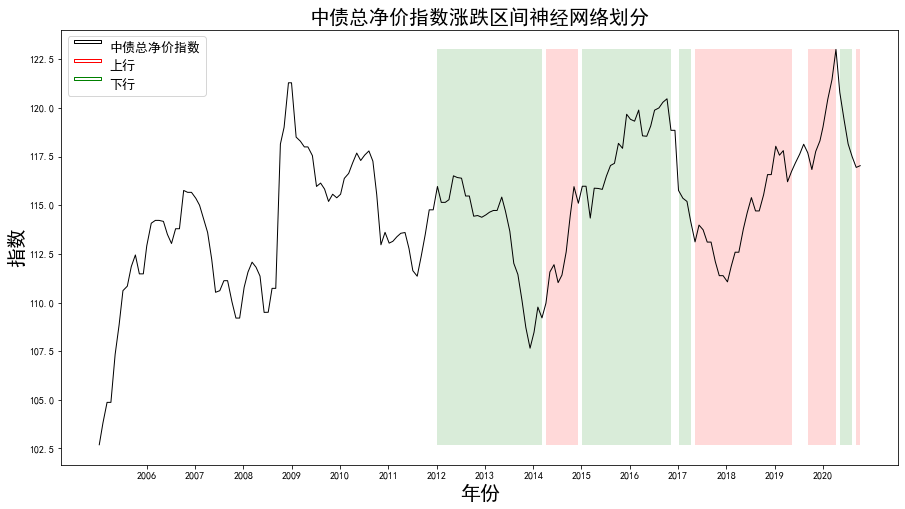

年化收益率 1.011
相对收益率 0.483
准确率 0.549
复杂度 2.151
区间错误率 ('3/12', '28/106')


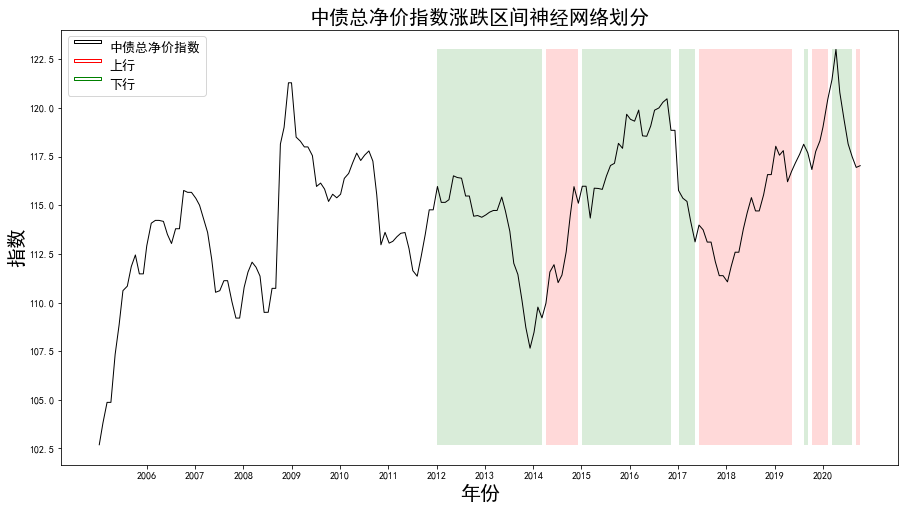

年化收益率 1.008
相对收益率 0.364
准确率 0.561
复杂度 2.151
区间错误率 ('3/12', '28/106')


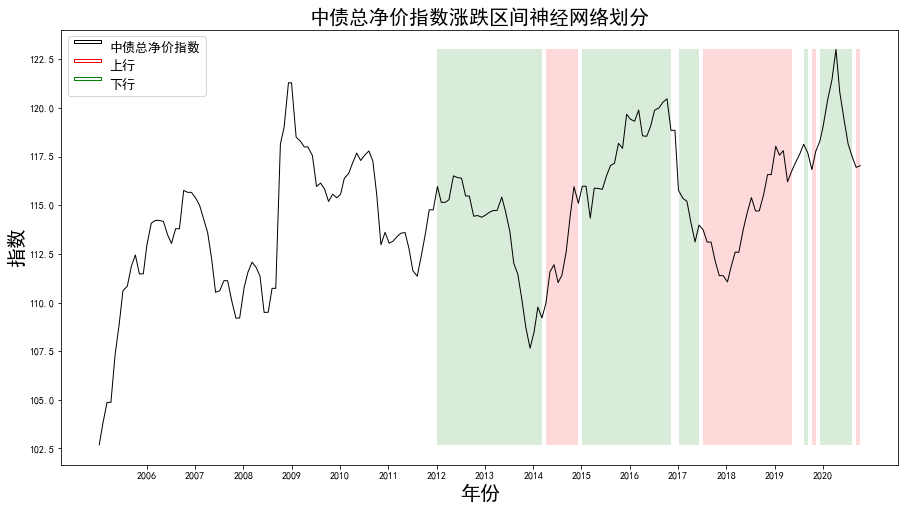

年化收益率 1.009
相对收益率 0.369
准确率 0.585
复杂度 2.151
区间错误率 ('3/12', '28/106')


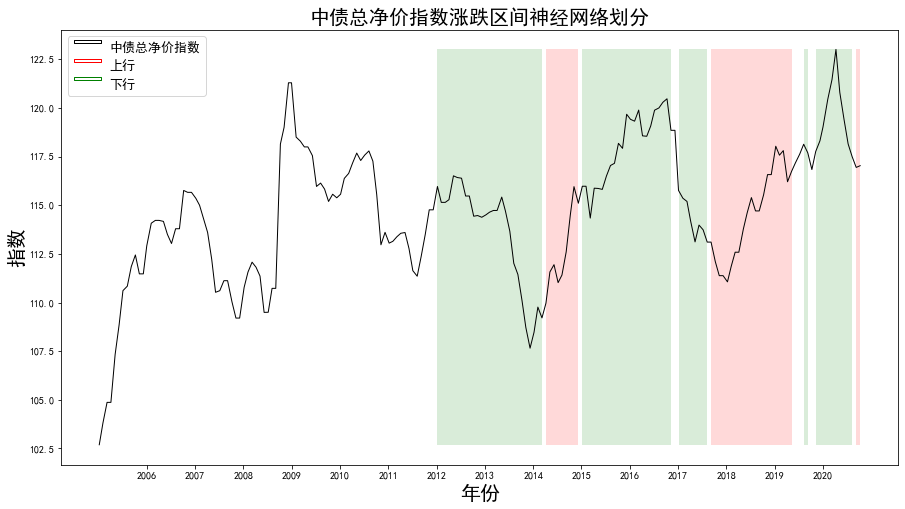

年化收益率 1.012
相对收益率 0.53
准确率 0.61
复杂度 2.151
区间错误率 ('2/12', '4/106')


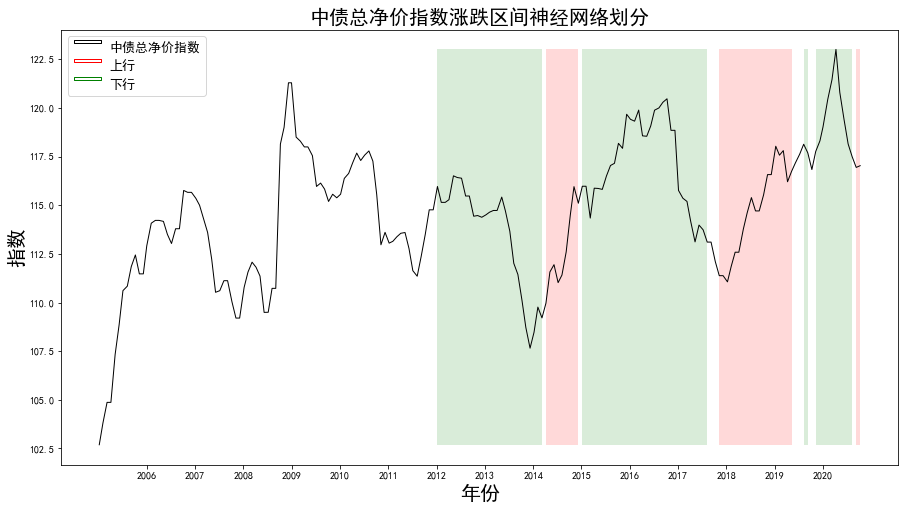

年化收益率 1.012
相对收益率 0.53
准确率 0.61
复杂度 2.151
区间错误率 ('2/12', '4/106')


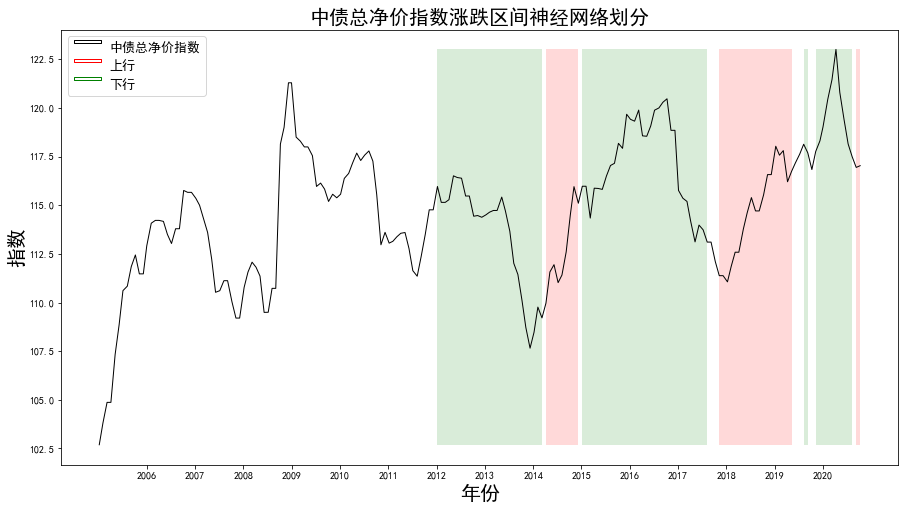

年化收益率 1.012
相对收益率 0.53
准确率 0.61
复杂度 2.33
区间错误率 ('2/13', '4/106')


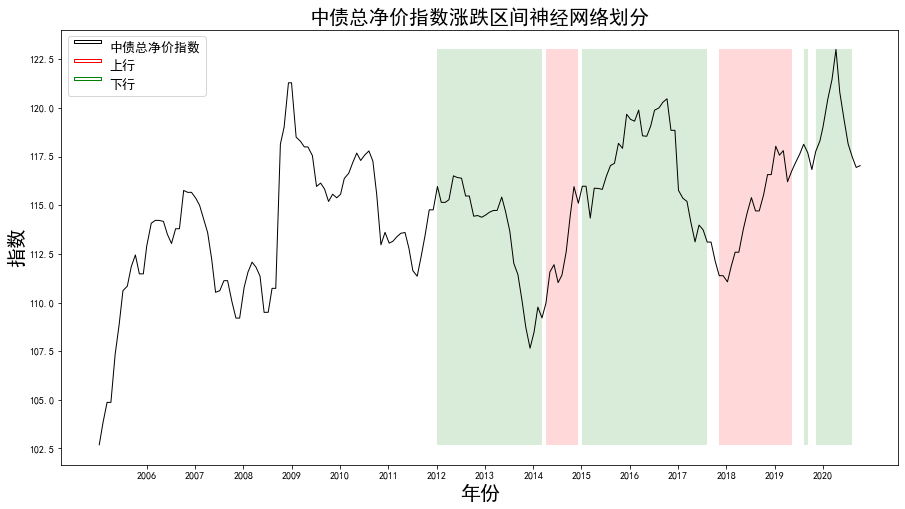

年化收益率 1.011
相对收益率 0.495
准确率 0.598
复杂度 2.689
区间错误率 ('3/15', '6/106')


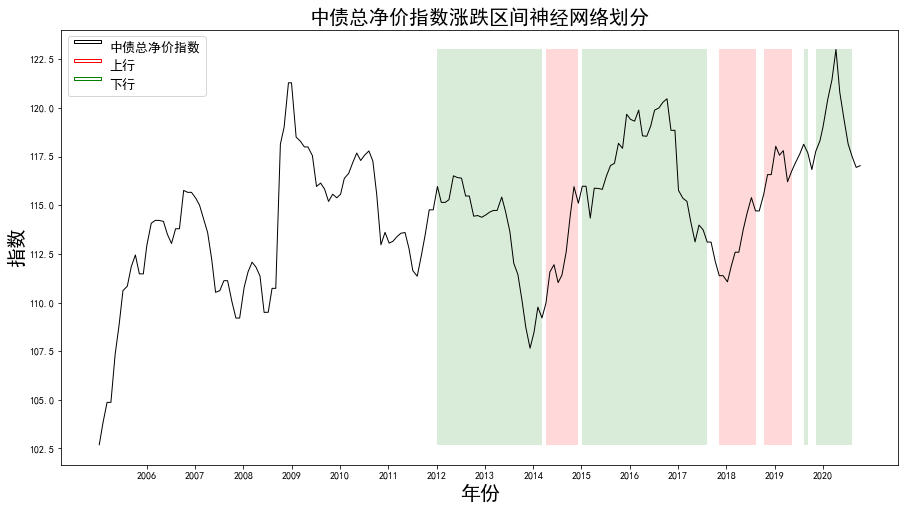

年化收益率 1.012
相对收益率 0.514
准确率 0.598
复杂度 3.047
区间错误率 ('4/17', '12/106')


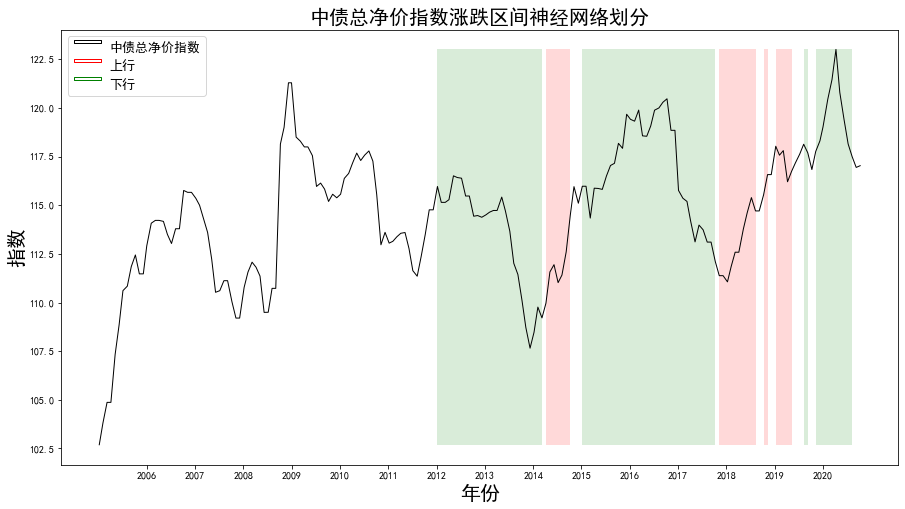

年化收益率 1.01
相对收益率 0.439
准确率 0.549
复杂度 3.764
区间错误率 ('5/21', '14/106')


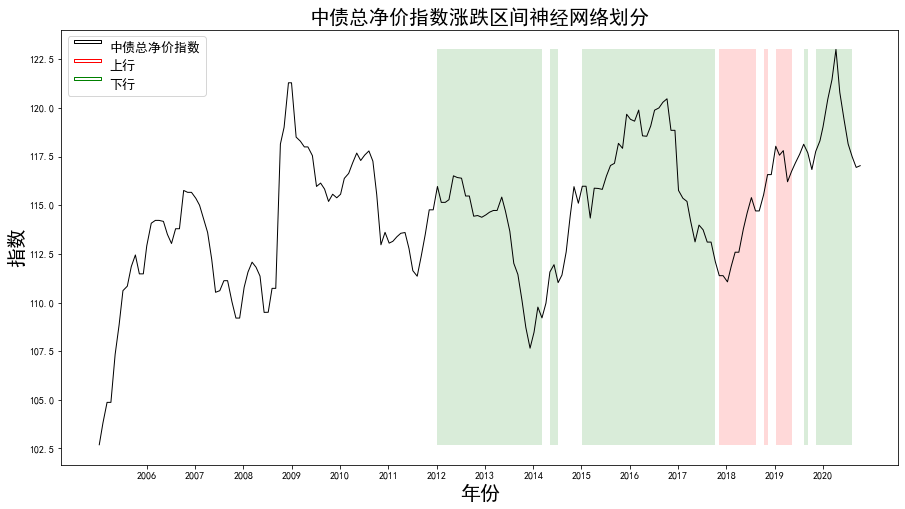

年化收益率 1.011
相对收益率 0.492
准确率 0.512
复杂度 4.123
区间错误率 ('6/23', '16/106')


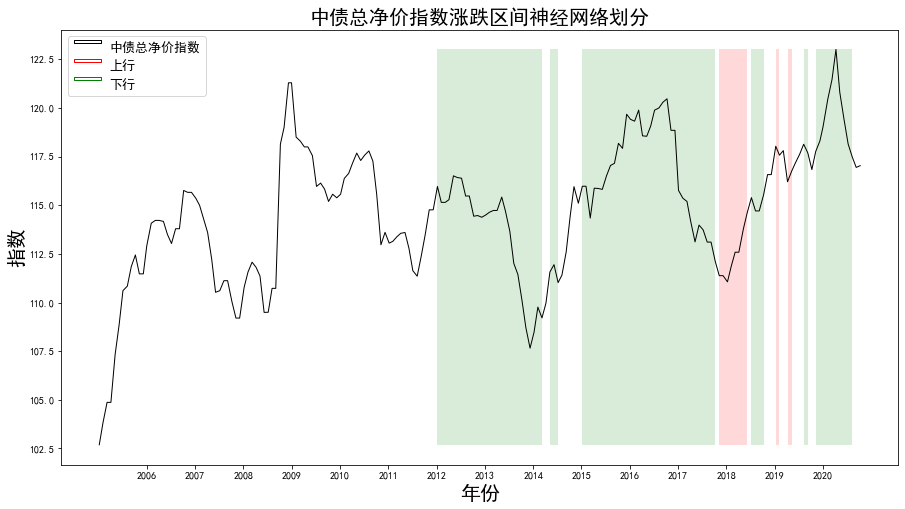

年化收益率 1.012
相对收益率 0.507
准确率 0.512
复杂度 3.764
区间错误率 ('5/21', '14/106')


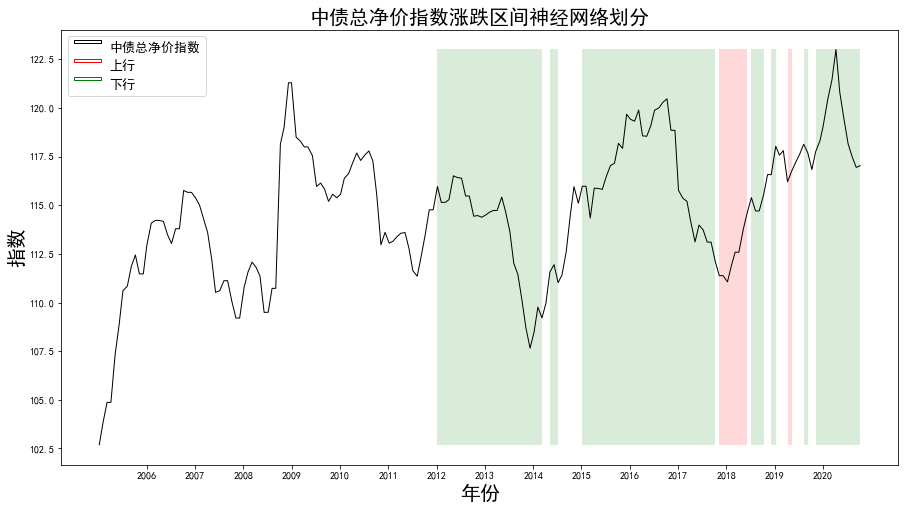

年化收益率 1.01
相对收益率 0.419
准确率 0.5
复杂度 4.123
区间错误率 ('6/23', '17/106')


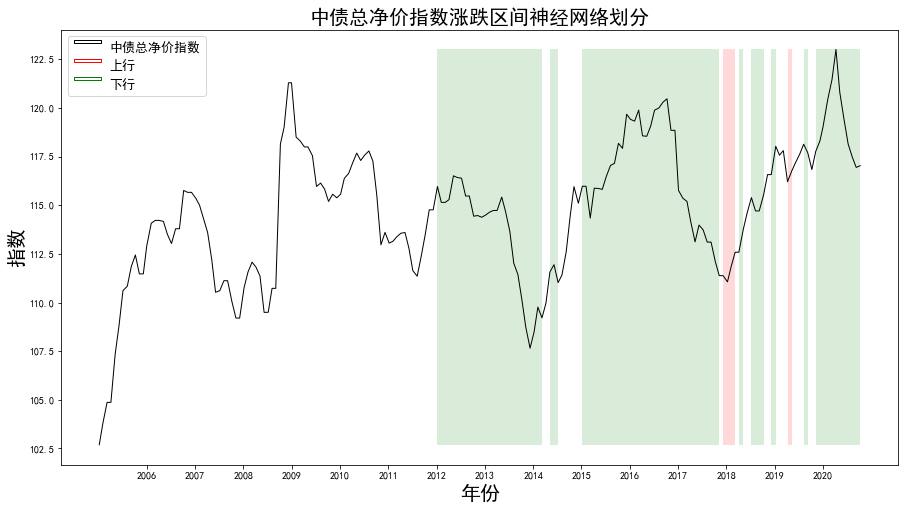

年化收益率 1.009
相对收益率 0.38
准确率 0.5
复杂度 3.764
区间错误率 ('6/21', '17/106')


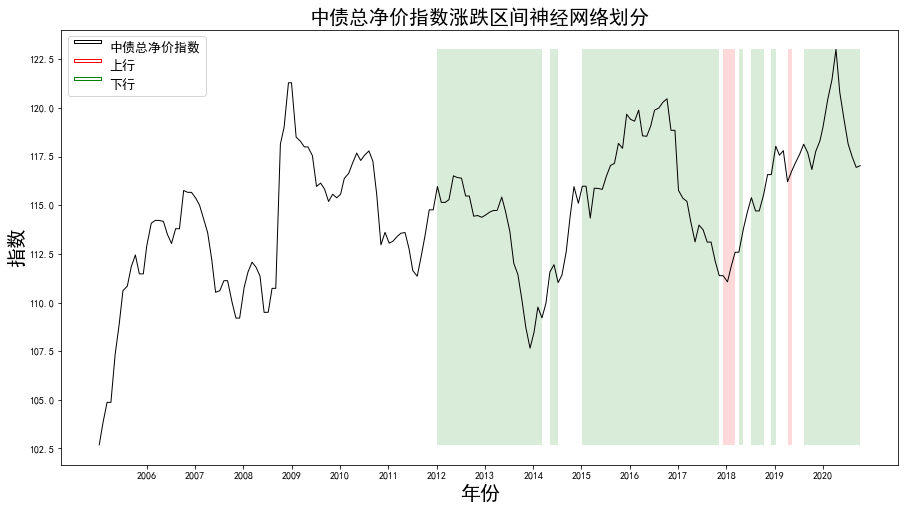

年化收益率 1.008
相对收益率 0.346
准确率 0.476
复杂度 4.123
区间错误率 ('8/23', '22/106')


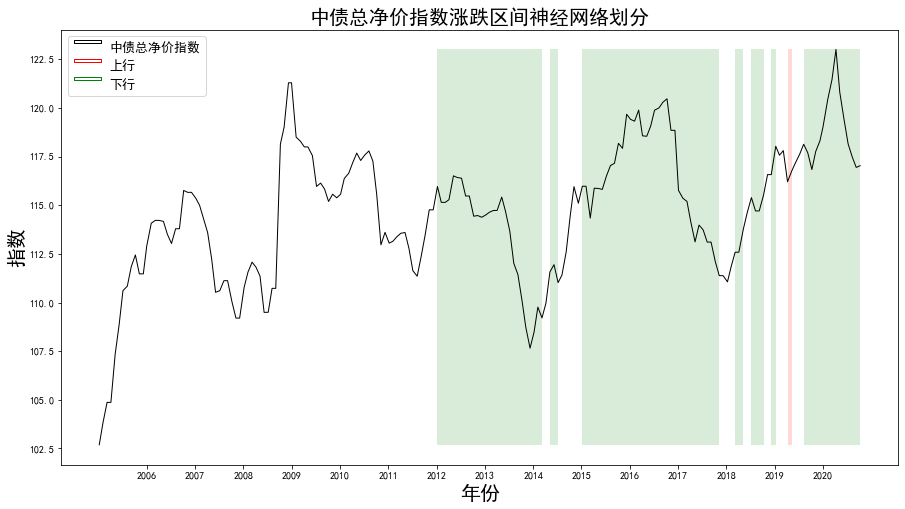

年化收益率 1.008
相对收益率 0.342
准确率 0.488
复杂度 3.764
区间错误率 ('6/21', '19/106')


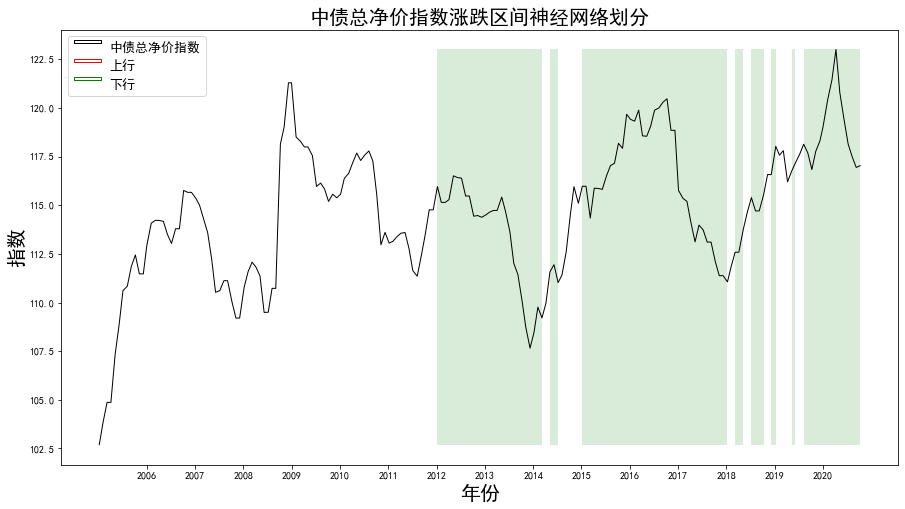

年化收益率 1.008
相对收益率 0.342
准确率 0.488
复杂度 3.764
区间错误率 ('6/21', '19/106')


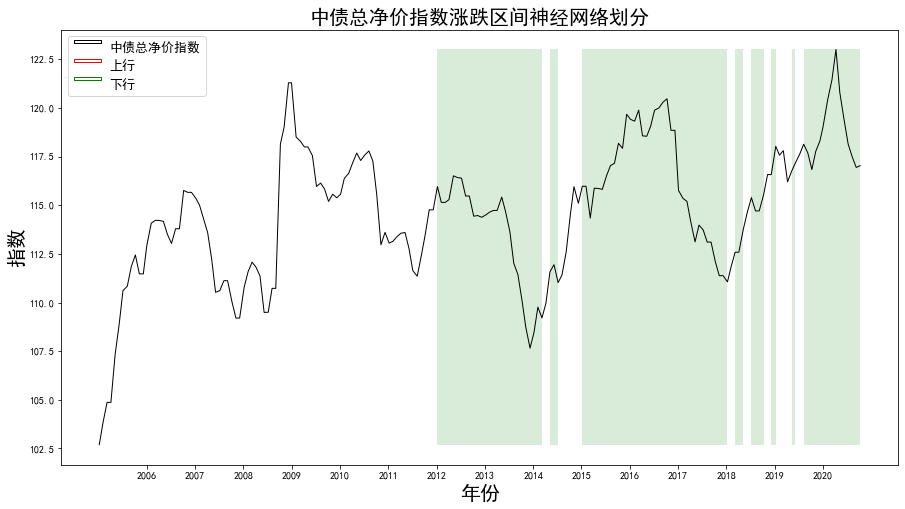

In [62]:
for ii in range(10,100,5):
    ii /= 100
    temp = -(-1) ** (np.array([i[0] for i in res_nnet2]) >= ii)
    l_n = len(d8) - len(temp)
    plt.rcParams['font.family']=['SimHei']
    fig, ax = plt.subplots(figsize=(15,8))
    ax.set_title('中债总净价指数涨跌区间神经网络划分',fontproperties='SimHei', size = 20)
    ax.plot(d8, data[0], color='black', linewidth = 1, label = '中债总净价指数')

    plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
    plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
    plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

    collection = collections.BrokenBarHCollection.span_where(
        d8[l_n:], ymin=min(data[0]), ymax=max(data[0]), where=temp == 1, facecolor='red', alpha=.15, label = '上行')
    ax.add_collection(collection)

    collection = collections.BrokenBarHCollection.span_where(
        d8[l_n:], ymin=min(data[0]), ymax=max(data[0]), where=temp == -1, facecolor='green', alpha=.15, label = '下行')
    ax.add_collection(collection)

    colors = ['black', 'red', 'green']
    new_legends = ["-"] * len(colors)
    markers = ['-'] * len(colors)

    _, labels = ax.get_legend_handles_labels()

    duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
    ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)


    p1 = round(profit(data[0][l_n:],temp),3)
    rp1 = round(          (profit(data[0][l_n:],temp)-1)/(profit(data[0][l_n:-24], ud[l_n:-24])    -1)  ,3)
    a1 = round(acc(temp[:-24], ud[l_n:-24]),3)
    c1 = round(cpx(temp)/base_cpx,3)
    w1 = wrong_div(data[0][l_n:], temp)

    print('年化收益率', p1)
    print('相对收益率', rp1)
    print('准确率', a1)
    print('复杂度', c1)
    print('区间错误率', w1)

    plt.show()